# ⚠️ Auto-generated Notebook
    
This notebook is automatically compiled from source files in `/workspaces/awesome-matrix/src/examples/02_dot_and_inner_products`.
**Do not edit this file directly** as your changes will be overwritten.

To make changes:
1. Edit the source file `/workspaces/awesome-matrix/src/examples/02_dot_and_inner_products/04_inner_product_definitions.py` instead
2. Run the compile script to regenerate this notebook

See [COMPILE.md](docs/COMPILE.md) for more information.


# 4. Inner Product Definitions: Beyond Dot Products

This example explores different inner product definitions and their applications.

Inner products generalize the concept of dot products to provide:

- Different ways to measure similarity between vectors
- New geometric interpretations in vector spaces
- Useful properties for function spaces and signal processing
- Applications in statistics, quantum mechanics, and other fields

In this tutorial, we'll build intuition for various inner product definitions.


## 4.1 Setup and Imports


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Create a nicer colormap for visualizing matrices
colors = [(0.8, 0.8, 1), (0.1, 0.3, 0.8)]  # Light blue to darker blue
cmap = LinearSegmentedColormap.from_list("custom_blue", colors, N=100)


## 4.2 Properties of Inner Products

An inner product is a function that takes two vectors and returns a scalar, satisfying:

1. **Linearity**: $\langle \alpha u + \beta v, w \rangle = \alpha \langle u, w \rangle + \beta \langle v, w \rangle$
2. **Conjugate Symmetry**: $\langle u, v \rangle = \overline{\langle v, u \rangle}$ (for real vectors, this means $\langle u, v \rangle = \langle v, u \rangle$)
3. **Positive Definiteness**: $\langle v, v \rangle \geq 0$ and $\langle v, v \rangle = 0$ if and only if $v = 0$

The standard dot product is just one example of an inner product. Let's review it first:


In [2]:
def standard_inner_product(u, v):
    """
    Standard (Euclidean) inner product: sum of products of corresponding elements.
    
    Args:
        u, v: PyTorch tensors of the same shape
        
    Returns:
        Inner product value (scalar)
    """
    return torch.dot(u, v)


In [3]:
# Let's test it with some vectors
u = torch.tensor([1., 2., 3.])
v = torch.tensor([4., 5., 6.])

dot_product = standard_inner_product(u, v)
print(f"Standard inner product: {dot_product}")

# Verify properties
# 1. Linearity
alpha, beta = 2.0, 3.0
w = torch.tensor([7., 8., 9.])

lin_left = standard_inner_product(alpha*u + beta*v, w)
lin_right = alpha*standard_inner_product(u, w) + beta*standard_inner_product(v, w)

print(f"Linearity: {lin_left} = {lin_right}, Equal: {torch.isclose(lin_left, lin_right)}")

# 2. Symmetry
sym_1 = standard_inner_product(u, v)
sym_2 = standard_inner_product(v, u)

print(f"Symmetry: {sym_1} = {sym_2}, Equal: {torch.isclose(sym_1, sym_2)}")

# 3. Positive definiteness
pos_def = standard_inner_product(u, u)
print(f"Positive definiteness: <u,u> = {pos_def} > 0")


Standard inner product: 32.0
Linearity: 466.0 = 466.0, Equal: True
Symmetry: 32.0 = 32.0, Equal: True
Positive definiteness: <u,u> = 14.0 > 0


## 4.3 Weighted Inner Products

A weighted inner product introduces a weight for each dimension, which can be useful when 
different features have different importance:

$$\langle u, v \rangle_W = \sum_{i=1}^{n} w_i u_i v_i = u^T W v$$

where $W$ is a diagonal matrix of weights.


In [4]:
def weighted_inner_product(u, v, weights):
    """
    Weighted inner product with diagonal weight matrix.
    
    Args:
        u, v: PyTorch tensors of the same shape
        weights: PyTorch tensor of weights for each dimension
        
    Returns:
        Weighted inner product value (scalar)
    """
    return torch.sum(weights * u * v)


In [5]:
# Create some weight vector
weights = torch.tensor([2., 1., 0.5])

weighted_product = weighted_inner_product(u, v, weights)
print(f"Weighted inner product: {weighted_product}")

# Compare with standard inner product
print(f"Standard inner product: {standard_inner_product(u, v)}")


Weighted inner product: 27.0
Standard inner product: 32.0


In [6]:
def visualize_weighted_inner_product(u, v, weights, figsize=(12, 8)):
    """
    Visualize the comparison between standard and weighted inner products.
    
    Args:
        u, v: Vectors to compare
        weights: Weights for each dimension
        figsize: Figure size
    """
    # Convert to numpy
    u_np = u.detach().cpu().numpy()
    v_np = v.detach().cpu().numpy()
    weights_np = weights.detach().cpu().numpy()
    
    # Calculate products
    products_std = u_np * v_np
    products_weighted = weights_np * u_np * v_np
    
    std_inner = np.sum(products_std)
    weighted_inner = np.sum(products_weighted)
    
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Bar colors
    colors_std = plt.cm.Blues(0.6 * np.ones_like(products_std))
    colors_weighted = plt.cm.Reds(0.6 * np.ones_like(products_weighted))
    
    # Create bar positions
    dim_labels = [f"dim {i+1}" for i in range(len(u_np))]
    x_pos = np.arange(len(dim_labels))
    
    # Plot standard inner product components
    bars1 = ax1.bar(x_pos, products_std, color=colors_std, 
                   alpha=0.7, label='Component products')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(dim_labels)
    ax1.set_ylabel('Value')
    ax1.set_title(f'Standard Inner Product: {std_inner:.2f}')
    
    # Add vector values as text
    for i, bar in enumerate(bars1):
        ax1.text(bar.get_x() + bar.get_width()/2., 0.1,
                f'u={u_np[i]:.1f}\nv={v_np[i]:.1f}', 
                ha='center', va='bottom', color='black', fontsize=10)
        
        height = bar.get_height()
        if height >= 0:
            va = 'bottom'
            y_pos = height + 0.1
        else:
            va = 'top'
            y_pos = height - 0.1
            
        ax1.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{products_std[i]:.1f}', 
                ha='center', va=va, color='black', fontsize=10)
    
    # Plot summary line for standard product
    ax1.axhline(y=std_inner, color='blue', linestyle='--', 
               label=f'Sum = {std_inner:.2f}')
    
    # Plot weighted inner product components
    bars2 = ax2.bar(x_pos, products_weighted, color=colors_weighted, 
                   alpha=0.7, label='Weighted component products')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(dim_labels)
    ax2.set_ylabel('Value')
    ax2.set_title(f'Weighted Inner Product: {weighted_inner:.2f}')
    
    # Add vector and weight values as text
    for i, bar in enumerate(bars2):
        ax2.text(bar.get_x() + bar.get_width()/2., 0.1,
                f'u={u_np[i]:.1f}\nv={v_np[i]:.1f}\nw={weights_np[i]:.1f}', 
                ha='center', va='bottom', color='black', fontsize=10)
        
        height = bar.get_height()
        if height >= 0:
            va = 'bottom'
            y_pos = height + 0.1
        else:
            va = 'top'
            y_pos = height - 0.1
            
        ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{products_weighted[i]:.1f}', 
                ha='center', va=va, color='black', fontsize=10)
    
    # Plot summary line for weighted product
    ax2.axhline(y=weighted_inner, color='red', linestyle='--', 
               label=f'Sum = {weighted_inner:.2f}')
    
    # Add legends
    ax1.legend()
    ax2.legend()
    
    # Add equations
    equation1 = r"$\langle u, v \rangle = \sum_i u_i v_i$"
    ax1.text(0.5, -0.15, equation1, transform=ax1.transAxes, 
            ha='center', va='center', fontsize=12)
    
    equation2 = r"$\langle u, v \rangle_W = \sum_i w_i u_i v_i$"
    ax2.text(0.5, -0.15, equation2, transform=ax2.transAxes, 
            ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()


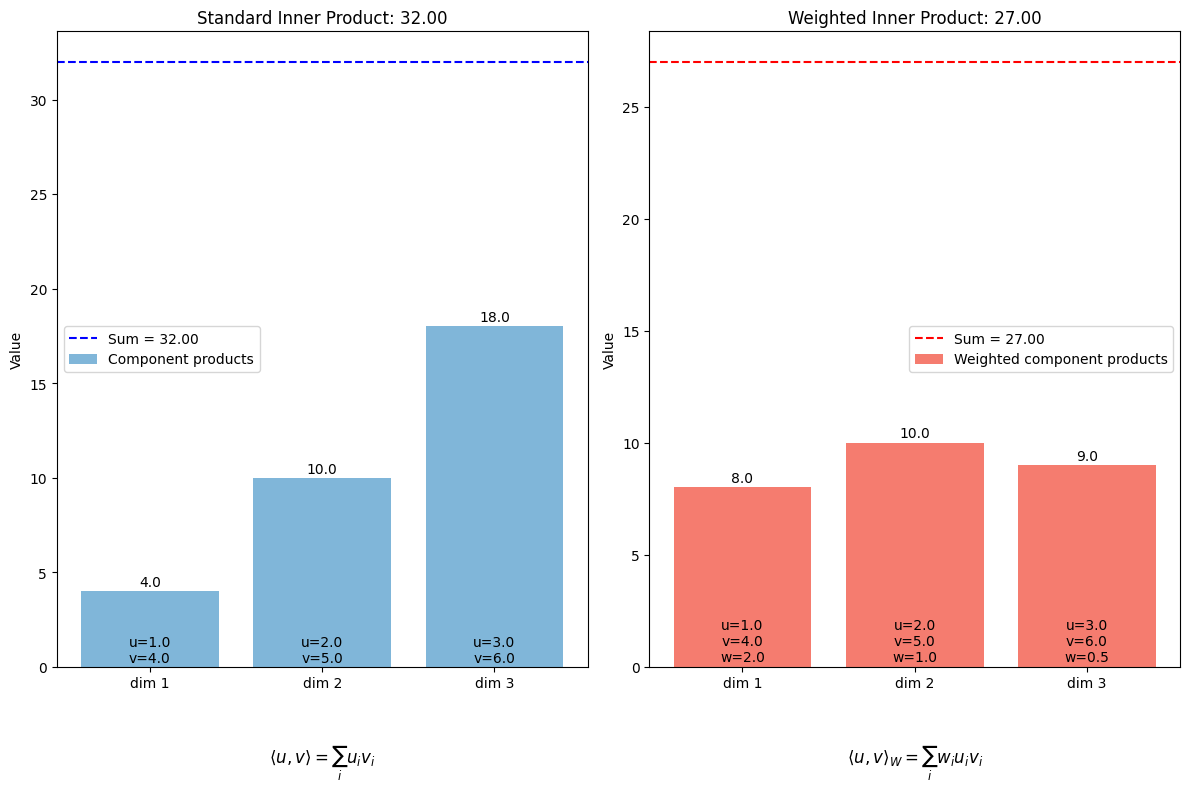

In [7]:
# Visualize weighted inner product
visualize_weighted_inner_product(u, v, weights)


## 4.4 Mahalanobis Inner Product

The Mahalanobis inner product generalizes the weighted inner product by using a positive-definite 
matrix $M$ instead of just diagonal weights:

$$\langle u, v \rangle_M = u^T M v$$

This is especially useful in statistics and machine learning for considering correlations 
between dimensions.


In [8]:
def mahalanobis_inner_product(u, v, M):
    """
    Mahalanobis inner product with a positive definite matrix M.
    
    Args:
        u, v: PyTorch tensors of the same shape
        M: Positive definite matrix
        
    Returns:
        Mahalanobis inner product value (scalar)
    """
    return torch.dot(u, torch.matmul(M, v))


In [9]:
# Create a positive definite matrix
M = torch.tensor([
    [2.0, 0.5, 0.1],
    [0.5, 1.0, 0.2],
    [0.1, 0.2, 0.5]
])

mahalanobis_product = mahalanobis_inner_product(u, v, M)
print(f"Mahalanobis inner product: {mahalanobis_product}")


Mahalanobis inner product: 40.70000076293945


Let's visualize how the Mahalanobis inner product transforms the geometry of the space:


In [10]:
def visualize_mahalanobis_distance(M, figsize=(10, 10)):
    """
    Visualize how the Mahalanobis inner product transforms the unit circle.
    
    Args:
        M: 2x2 positive definite matrix
        figsize: Figure size
    """
    # Convert to numpy
    M_np = M.detach().cpu().numpy()
    
    # Create a circle of points
    theta = np.linspace(0, 2*np.pi, 100)
    circle_x = np.cos(theta)
    circle_y = np.sin(theta)
    circle_points = np.column_stack((circle_x, circle_y))
    
    # Calculate Mahalanobis distances (distance from origin in Mahalanobis space)
    mahalanobis_distances = np.zeros(len(circle_points))
    transformed_points = np.zeros_like(circle_points)
    
    for i, point in enumerate(circle_points):
        # Calculate the Mahalanobis distance
        mahalanobis_distances[i] = np.sqrt(point @ M_np @ point)
        
        # Transform the point to create the ellipse
        # Points with constant Mahalanobis distance form an ellipse
        # We use M^(-1/2) to transform them
        eigenvalues, eigenvectors = np.linalg.eigh(M_np)
        M_sqrt_inv = eigenvectors @ np.diag(1.0/np.sqrt(eigenvalues)) @ eigenvectors.T
        transformed_points[i] = M_sqrt_inv @ point
    
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot the unit circle
    ax1.plot(circle_x, circle_y, 'b-', linewidth=2, label='Unit Circle')
    ax1.scatter(0, 0, color='red', s=100, zorder=10, label='Origin')
    
    # Add some vectors and their Mahalanobis distances
    vectors = [
        [1.0, 0.0],  # Right
        [0.0, 1.0],  # Up
        [0.7, 0.7],  # Diagonal
        [-0.5, 0.8]  # Another direction
    ]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(vectors)))
    
    for i, vec in enumerate(vectors):
        # Plot the vector
        ax1.arrow(0, 0, vec[0], vec[1], head_width=0.1, head_length=0.1,
                 fc=colors[i], ec=colors[i], label=f'v{i+1}')
        
        # Calculate and display Mahalanobis distance
        maha_dist = np.sqrt(np.array(vec) @ M_np @ np.array(vec))
        ax1.text(vec[0]*1.1, vec[1]*1.1, f'Dist: {maha_dist:.2f}', 
                fontsize=10, color=colors[i])
        
        # Plot the transformed vector in the second plot
        transformed_vec = M_sqrt_inv @ np.array(vec)
        ax2.arrow(0, 0, transformed_vec[0], transformed_vec[1], 
                 head_width=0.1, head_length=0.1,
                 fc=colors[i], ec=colors[i], label=f'v{i+1} transformed')
        
        # Calculate and display Euclidean distance of transformed vector
        eucl_dist = np.linalg.norm(transformed_vec)
        ax2.text(transformed_vec[0]*1.1, transformed_vec[1]*1.1, 
                f'Dist: {eucl_dist:.2f}', fontsize=10, color=colors[i])
    
    # Plot the transformed circle (ellipse)
    ax2.plot(transformed_points[:, 0], transformed_points[:, 1], 
            'r-', linewidth=2, label='Transformed Unit Circle')
    ax2.scatter(0, 0, color='red', s=100, zorder=10, label='Origin')
    
    # Set axis properties
    for ax in [ax1, ax2]:
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.grid(True)
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        ax.set_aspect('equal')
        ax.legend(loc='upper right', fontsize=8)
    
    ax1.set_title('Euclidean Space with Mahalanobis Distances')
    ax2.set_title('Transformed Space (Euclidean Distances)')
    
    # Add matrix information
    matrix_str = np.array2string(M_np, precision=2, separator=', ')
    fig.suptitle(f'Mahalanobis Inner Product with M =\n{matrix_str}', fontsize=14)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


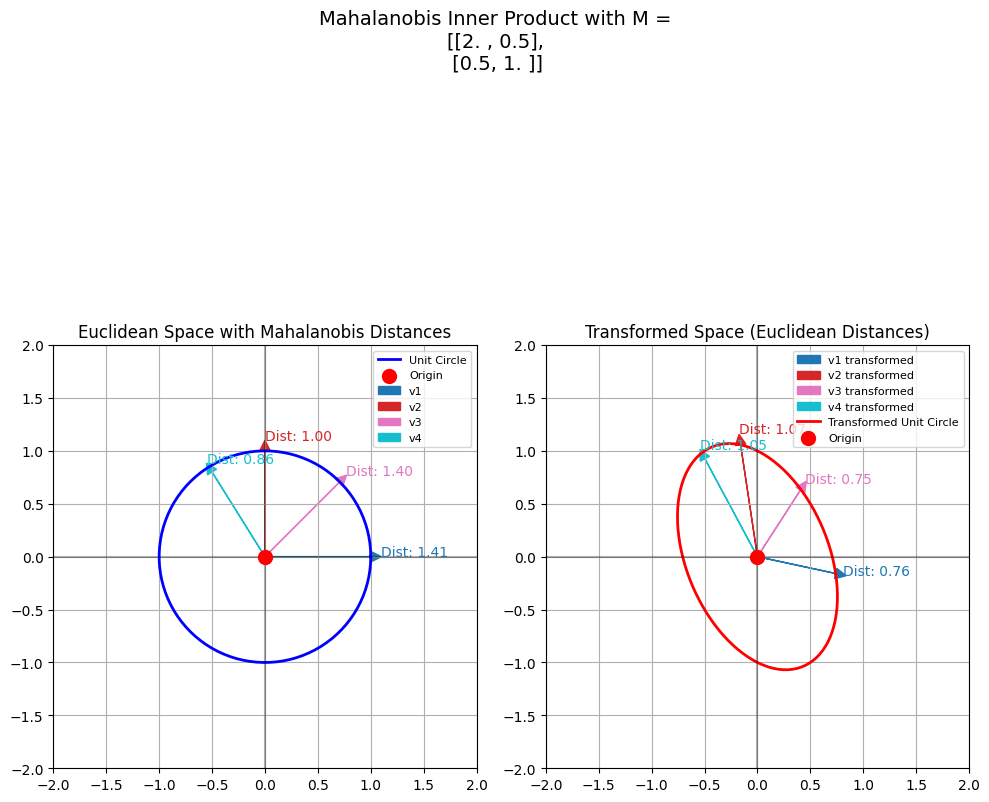

In [11]:
# Create a 2x2 positive definite matrix
M_2d = torch.tensor([
    [2.0, 0.5],
    [0.5, 1.0]
])

visualize_mahalanobis_distance(M_2d)


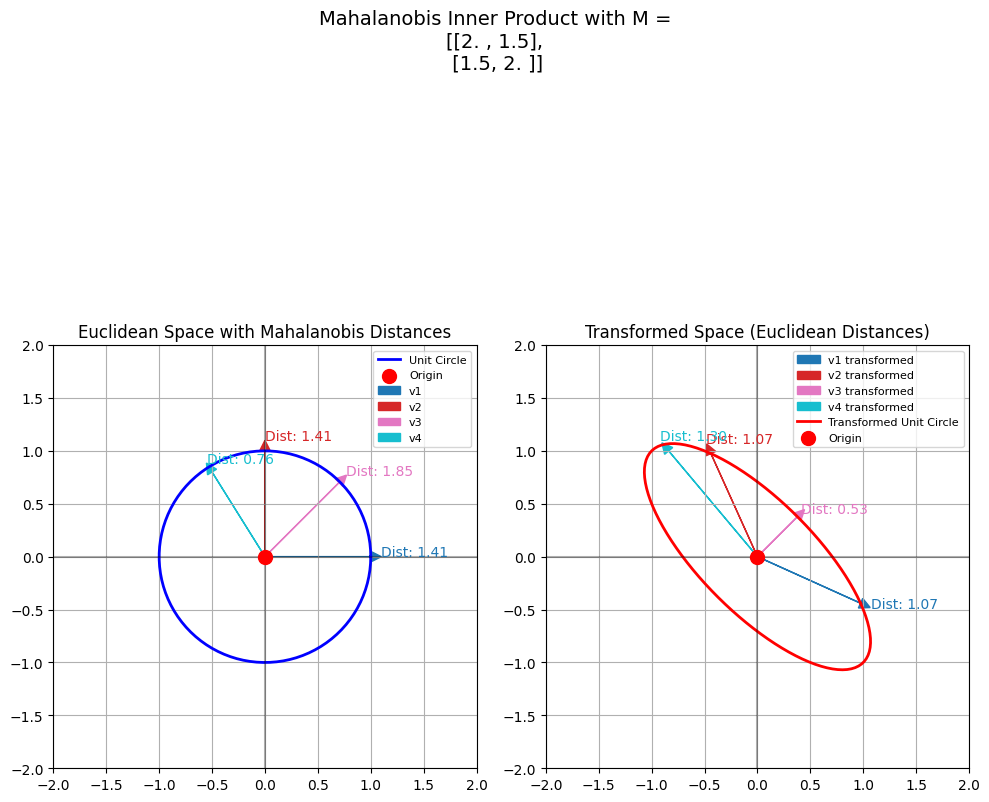

In [12]:
# Try another matrix with stronger correlation
M_2d_strong = torch.tensor([
    [2.0, 1.5],
    [1.5, 2.0]
])

visualize_mahalanobis_distance(M_2d_strong)


## 4.5 Inner Products in Function Spaces

Inner products can also be defined on function spaces. For continuous functions on $[a,b]$, 
a common inner product is:

$$\langle f, g \rangle = \int_{a}^{b} f(x)g(x) dx$$

Let's discretize and visualize this concept:


In [13]:
def function_inner_product(f_values, g_values, x_range):
    """
    Approximate inner product of two functions using discretization.
    
    Args:
        f_values, g_values: Function values at discrete points
        x_range: Range of x values
        
    Returns:
        Approximate inner product value
    """
    # Calculate width of each interval
    dx = (x_range[1] - x_range[0]) / (len(f_values) - 1)
    
    # Compute the inner product as a sum
    return torch.sum(f_values * g_values) * dx


In [14]:
# Create some functions
x = torch.linspace(0, 2*np.pi, 200)
f = torch.sin(x)
g1 = torch.sin(2*x)       # Orthogonal to f
g2 = torch.sin(x + 0.5)   # Not orthogonal to f

# Calculate inner products
inner_product_f_g1 = function_inner_product(f, g1, (0, 2*np.pi))
inner_product_f_g2 = function_inner_product(f, g2, (0, 2*np.pi))

print(f"Inner product <sin(x), sin(2x)>: {inner_product_f_g1:.5f}")
print(f"Inner product <sin(x), sin(x+0.5)>: {inner_product_f_g2:.5f}")


Inner product <sin(x), sin(2x)>: 0.00000
Inner product <sin(x), sin(x+0.5)>: 2.75701


In [15]:
def visualize_function_inner_product(f_values, g_values, x_values, x_range, figsize=(12, 8)):
    """
    Visualize the inner product of two functions.
    
    Args:
        f_values, g_values: Function values
        x_values: Domain values
        x_range: Range of x values
        figsize: Figure size
    """
    # Convert to numpy
    x_np = x_values.detach().cpu().numpy()
    f_np = f_values.detach().cpu().numpy()
    g_np = g_values.detach().cpu().numpy()
    
    # Calculate product function
    product = f_np * g_np
    
    # Calculate inner product
    dx = (x_range[1] - x_range[0]) / (len(f_values) - 1)
    inner_product = np.sum(product) * dx
    
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Plot the functions
    ax1.plot(x_np, f_np, 'b-', linewidth=2, label='f(x)')
    ax1.plot(x_np, g_np, 'r-', linewidth=2, label='g(x)')
    ax1.grid(True)
    ax1.set_xlabel('x')
    ax1.set_ylabel('Function value')
    ax1.set_title('Functions')
    ax1.legend()
    
    # Plot the product and area
    ax2.plot(x_np, product, 'g-', linewidth=2, label='f(x)g(x)')
    ax2.fill_between(x_np, product, alpha=0.3, color='green')
    ax2.grid(True)
    ax2.set_xlabel('x')
    ax2.set_ylabel('Product value')
    ax2.set_title(f'Product function: Area = {inner_product:.5f}')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax2.legend()
    
    # Add inner product information
    fig.suptitle(f'Function Inner Product: <f,g> = {inner_product:.5f}', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return inner_product


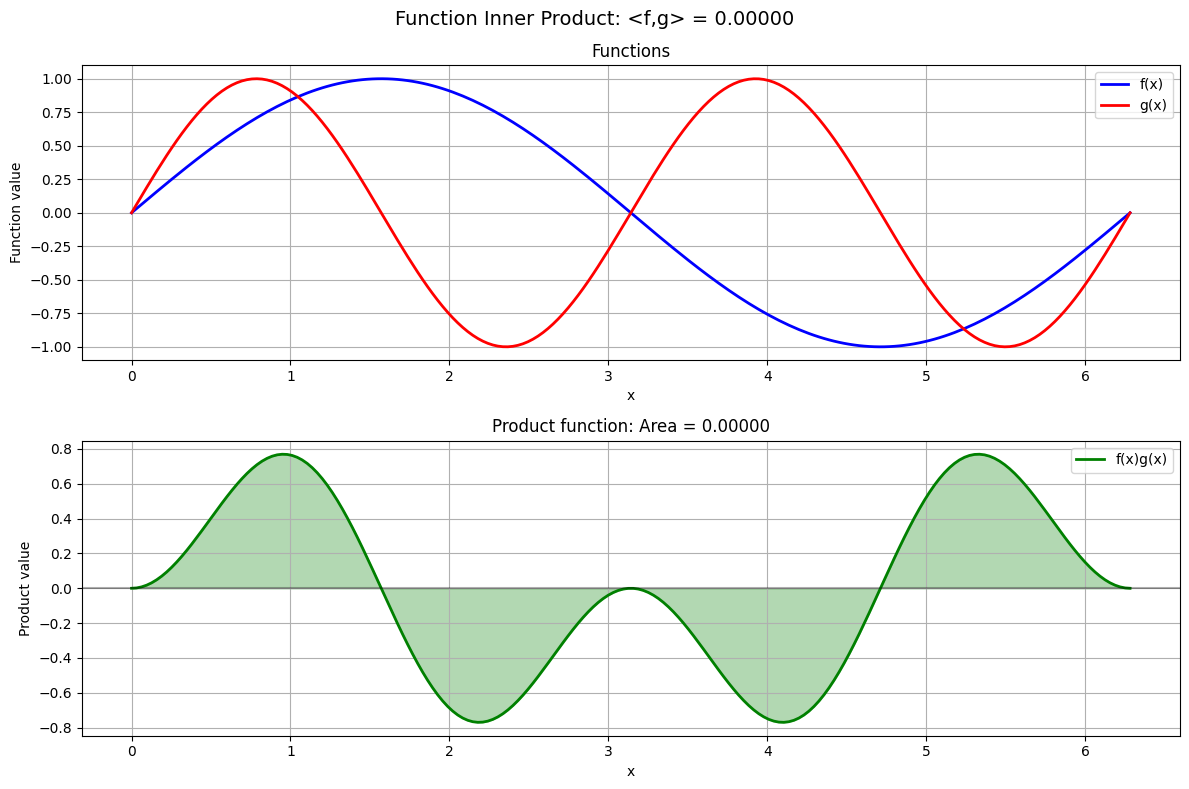

np.float32(2.0701393e-08)

In [16]:
# Visualize sin(x) and sin(2x) - orthogonal functions
visualize_function_inner_product(f, g1, x, (0, 2*np.pi))


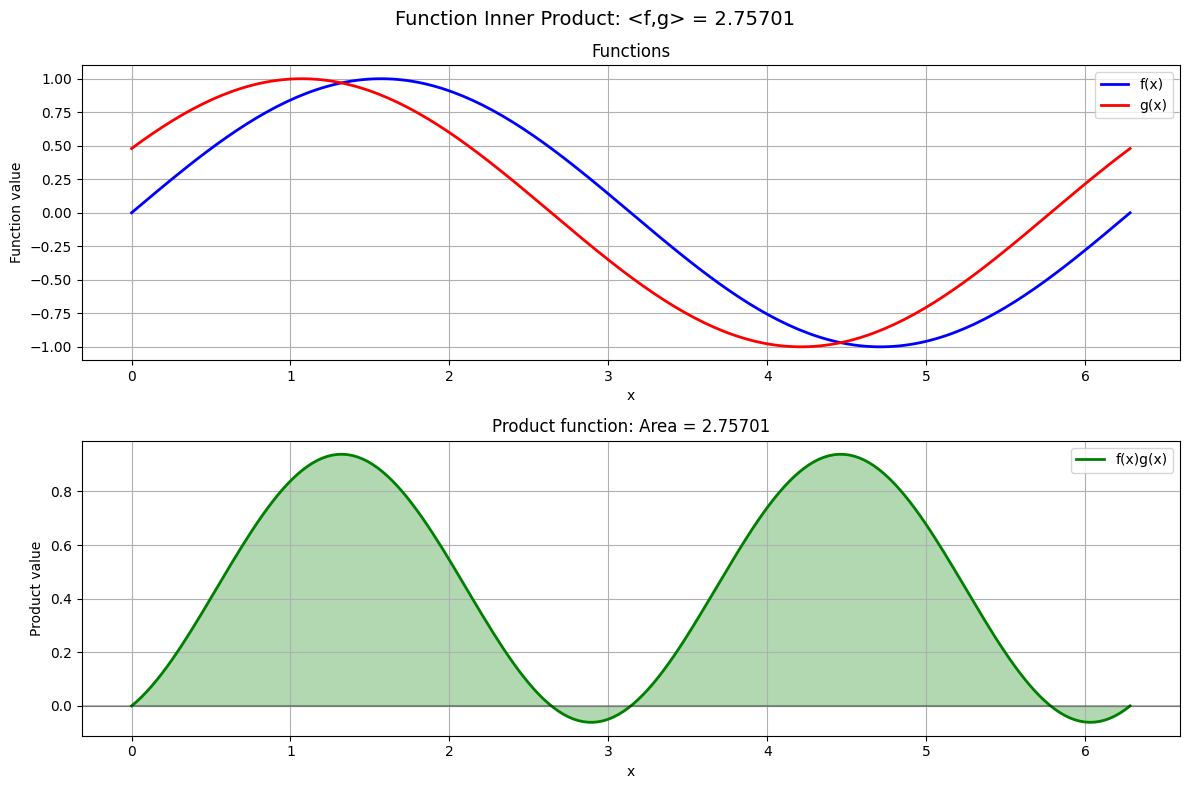

np.float32(2.7570066)

In [17]:
# Visualize sin(x) and sin(x+0.5) - non-orthogonal functions
visualize_function_inner_product(f, g2, x, (0, 2*np.pi))


## 4.6 Weighted Function Inner Products

We can also define weighted inner products for functions:

$$\langle f, g \rangle_w = \int_{a}^{b} w(x)f(x)g(x) dx$$

This is useful when certain regions of the domain are more important than others.


In [18]:
def weighted_function_inner_product(f_values, g_values, weight_values, x_range):
    """
    Approximate weighted inner product of two functions.
    
    Args:
        f_values, g_values: Function values at discrete points
        weight_values: Weight function values at discrete points
        x_range: Range of x values
        
    Returns:
        Approximate weighted inner product value
    """
    # Calculate width of each interval
    dx = (x_range[1] - x_range[0]) / (len(f_values) - 1)
    
    # Compute the inner product as a sum
    return torch.sum(weight_values * f_values * g_values) * dx


In [19]:
# Define a weight function
w = torch.exp(-((x - 3)/0.5)**2)  # Gaussian centered at x=3

# Calculate weighted inner products
weighted_inner_product_f_g1 = weighted_function_inner_product(f, g1, w, (0, 2*np.pi))
weighted_inner_product_f_g2 = weighted_function_inner_product(f, g2, w, (0, 2*np.pi))

print(f"Weighted inner product <sin(x), sin(2x)>_w: {weighted_inner_product_f_g1:.5f}")
print(f"Weighted inner product <sin(x), sin(x+0.5)>_w: {weighted_inner_product_f_g2:.5f}")


Weighted inner product <sin(x), sin(2x)>_w: -0.18206
Weighted inner product <sin(x), sin(x+0.5)>_w: 0.05185


In [20]:
def visualize_weighted_function_inner_product(f_values, g_values, weight_values, 
                                              x_values, x_range, figsize=(12, 10)):
    """
    Visualize the weighted inner product of two functions.
    
    Args:
        f_values, g_values: Function values
        weight_values: Weight function values
        x_values: Domain values
        x_range: Range of x values
        figsize: Figure size
    """
    # Convert to numpy
    x_np = x_values.detach().cpu().numpy()
    f_np = f_values.detach().cpu().numpy()
    g_np = g_values.detach().cpu().numpy()
    w_np = weight_values.detach().cpu().numpy()
    
    # Calculate products
    product = f_np * g_np
    weighted_product = w_np * product
    
    # Calculate inner products
    dx = (x_range[1] - x_range[0]) / (len(f_values) - 1)
    inner_product = np.sum(product) * dx
    weighted_inner_product = np.sum(weighted_product) * dx
    
    # Set up the figure
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize)
    
    # Plot the functions
    ax1.plot(x_np, f_np, 'b-', linewidth=2, label='f(x)')
    ax1.plot(x_np, g_np, 'r-', linewidth=2, label='g(x)')
    ax1.plot(x_np, w_np, 'g-', linewidth=2, label='Weight w(x)')
    ax1.grid(True)
    ax1.set_xlabel('x')
    ax1.set_ylabel('Function value')
    ax1.set_title('Functions and Weight')
    ax1.legend()
    
    # Plot the unweighted product
    ax2.plot(x_np, product, 'purple', linewidth=2, label='f(x)g(x)')
    ax2.fill_between(x_np, product, alpha=0.3, color='purple')
    ax2.grid(True)
    ax2.set_xlabel('x')
    ax2.set_ylabel('Product value')
    ax2.set_title(f'Unweighted Product: Area = {inner_product:.5f}')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax2.legend()
    
    # Plot the weighted product
    ax3.plot(x_np, weighted_product, 'orange', linewidth=2, label='w(x)f(x)g(x)')
    ax3.fill_between(x_np, weighted_product, alpha=0.3, color='orange')
    ax3.grid(True)
    ax3.set_xlabel('x')
    ax3.set_ylabel('Weighted product value')
    ax3.set_title(f'Weighted Product: Area = {weighted_inner_product:.5f}')
    ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax3.legend()
    
    # Add inner product information
    fig.suptitle(f'Function Inner Products:\n' + 
                f'Standard: <f,g> = {inner_product:.5f}\n' +
                f'Weighted: <f,g>_w = {weighted_inner_product:.5f}', 
                fontsize=14)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return inner_product, weighted_inner_product


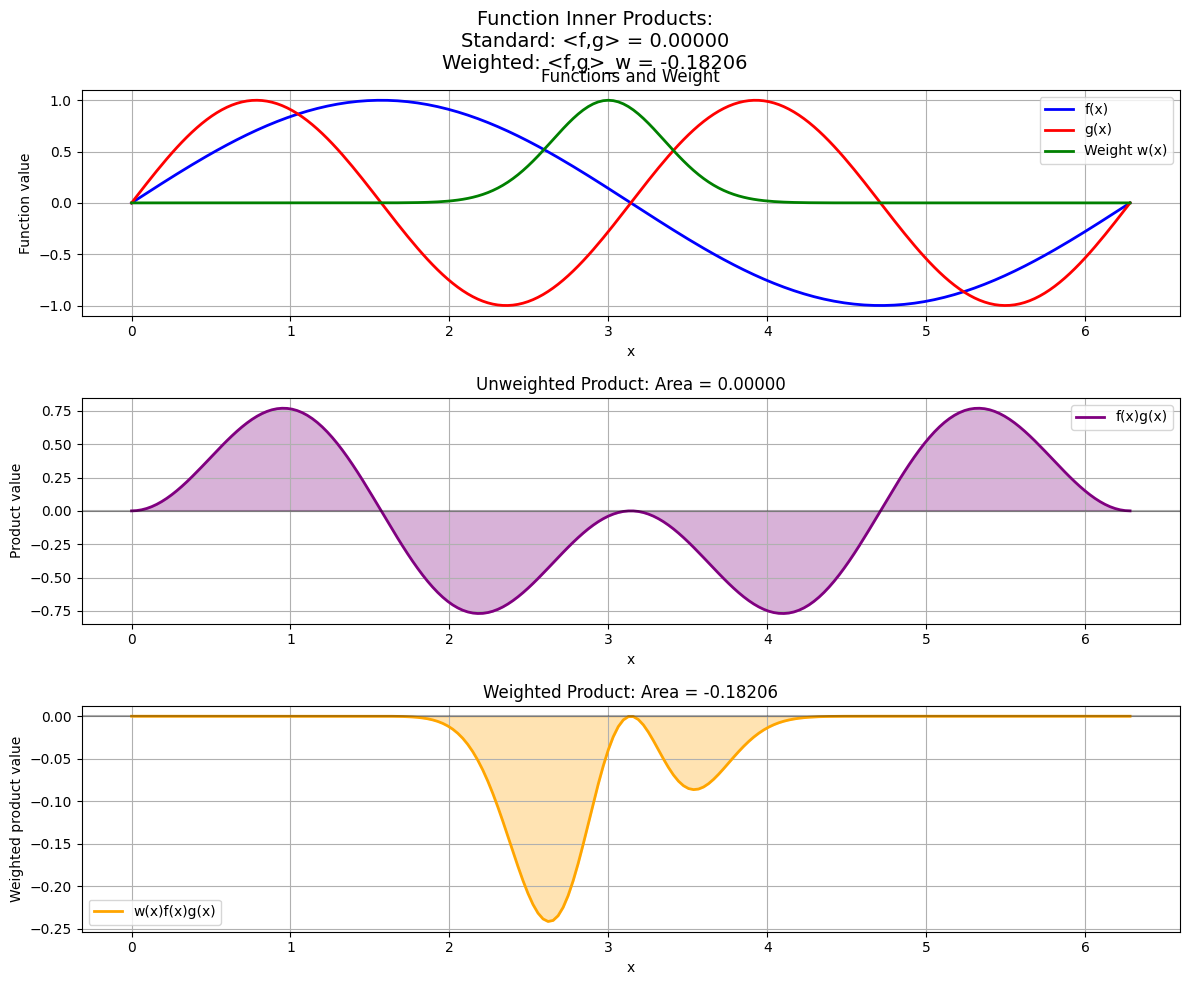

(np.float32(2.0701393e-08), np.float32(-0.18206003))

In [21]:
# Visualize weighted inner product for sin(x) and sin(2x)
visualize_weighted_function_inner_product(f, g1, w, x, (0, 2*np.pi))


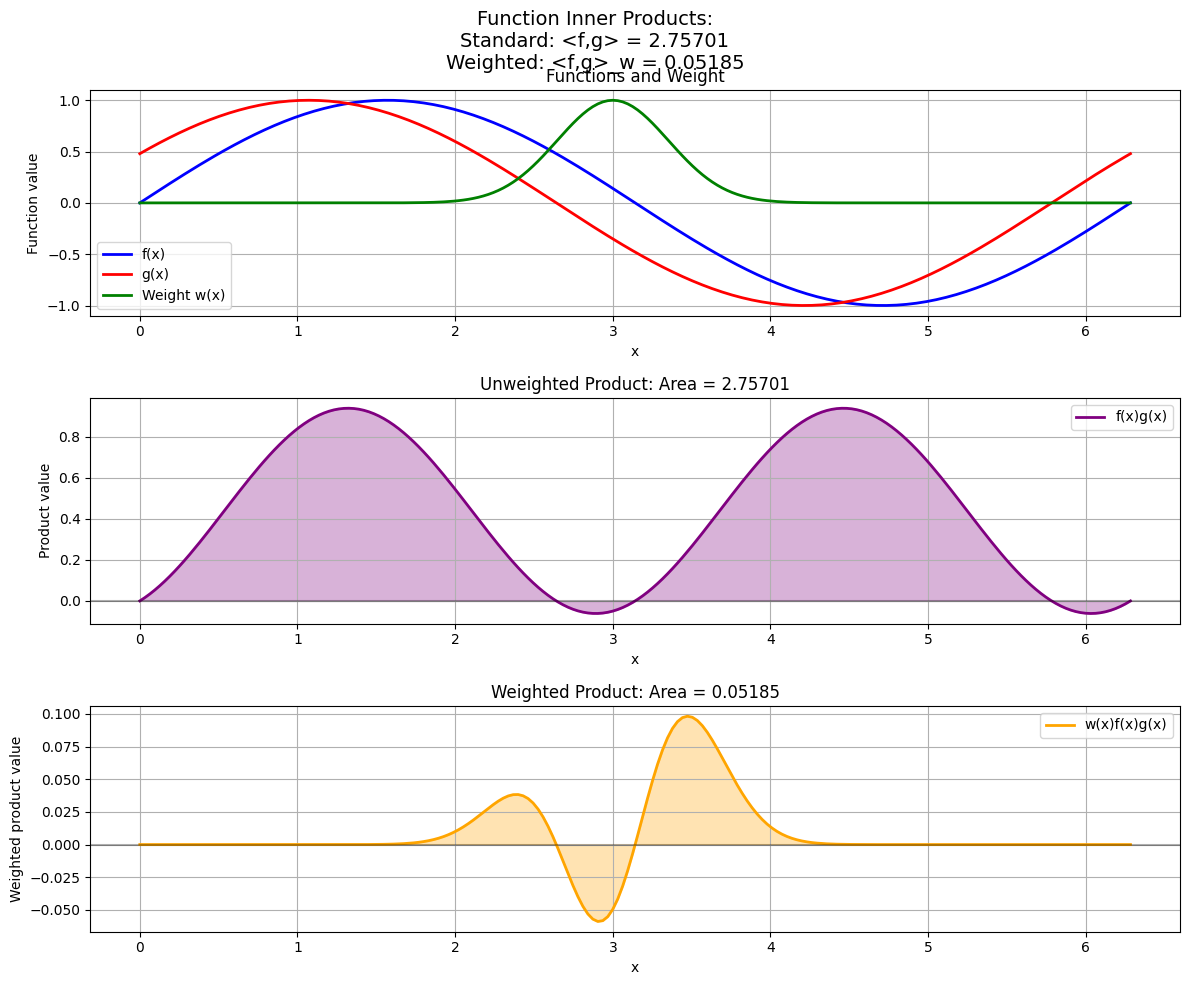

(np.float32(2.7570066), np.float32(0.05185107))

In [22]:
# Visualize weighted inner product for sin(x) and sin(x+0.5)
visualize_weighted_function_inner_product(f, g2, w, x, (0, 2*np.pi))


## 4.7 Applications: Orthogonal Polynomial Basis

Inner products are essential for defining orthogonal function families like 
Legendre polynomials. Let's demonstrate how inner products define orthogonality:


In [23]:
def legendre_polynomial(n, x):
    """
    Evaluate the nth Legendre polynomial at points x.
    
    Args:
        n: Order of the polynomial
        x: Points to evaluate at
        
    Returns:
        Legendre polynomial values
    """
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return x
    else:
        # Recurrence relation for Legendre polynomials
        return ((2*n-1) * x * legendre_polynomial(n-1, x) - 
                (n-1) * legendre_polynomial(n-2, x)) / n


In [24]:
# Create evaluation points in the Legendre domain [-1, 1]
x_leg = torch.linspace(-1, 1, 200)

# Generate Legendre polynomials
legendre_polys = [legendre_polynomial(n, x_leg) for n in range(5)]


In [25]:
def visualize_orthogonal_polynomials(polynomials, x_values, figsize=(12, 10)):
    """
    Visualize orthogonal polynomials and their inner products.
    
    Args:
        polynomials: List of polynomial values at x_values
        x_values: Domain values
        figsize: Figure size
    """
    # Convert to numpy
    x_np = x_values.detach().cpu().numpy()
    poly_np = [p.detach().cpu().numpy() for p in polynomials]
    
    # Calculate inner products
    n_polys = len(polynomials)
    inner_products = torch.zeros((n_polys, n_polys))
    
    for i in range(n_polys):
        for j in range(n_polys):
            inner_products[i, j] = function_inner_product(
                polynomials[i], polynomials[j], (-1, 1))
    
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot the polynomials
    for i, poly in enumerate(poly_np):
        ax1.plot(x_np, poly, linewidth=2, label=f'P_{i}(x)')
    
    ax1.grid(True)
    ax1.set_xlabel('x')
    ax1.set_ylabel('P(x)')
    ax1.set_title('Legendre Polynomials')
    ax1.legend()
    
    # Plot the inner product matrix
    inner_products_np = inner_products.detach().cpu().numpy()
    im = ax2.imshow(inner_products_np, cmap=cmap)
    plt.colorbar(im, ax=ax2)
    
    # Add inner product values
    for i in range(n_polys):
        for j in range(n_polys):
            if abs(inner_products_np[i, j]) < 0.05:
                # Orthogonal polynomials should have near-zero inner product
                text_color = 'green'
            else:
                text_color = 'black'
                
            ax2.text(j, i, f'{inner_products_np[i, j]:.2f}', 
                    ha='center', va='center', color=text_color)
    
    ax2.set_xticks(np.arange(n_polys))
    ax2.set_yticks(np.arange(n_polys))
    ax2.set_xticklabels([f'P_{i}' for i in range(n_polys)])
    ax2.set_yticklabels([f'P_{i}' for i in range(n_polys)])
    ax2.set_title('Inner Products <P_i, P_j>')
    
    plt.tight_layout()
    plt.show()


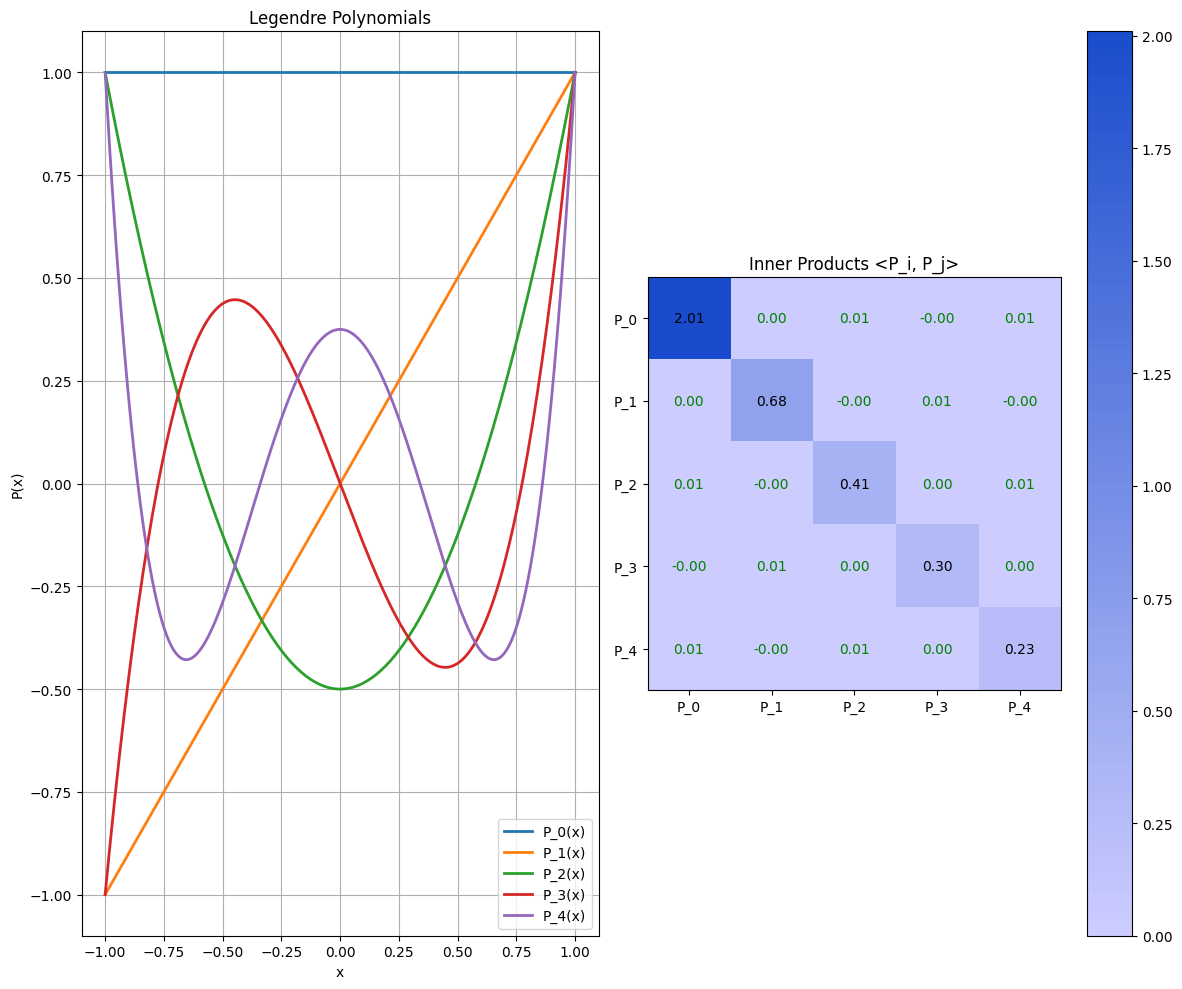

In [26]:
# Visualize Legendre polynomials and their orthogonality
visualize_orthogonal_polynomials(legendre_polys, x_leg)


## 4.8 Applications: Generalized Linear Models

In statistics and machine learning, different inner products lead to different distance metrics,
which affect model behavior. Let's explore this with a simple example:


In [27]:
def visualize_inner_product_metrics(points, labels, inner_product_matrices, 
                                   names, figsize=(15, 8)):
    """
    Visualize how different inner products affect distance metrics in 2D.
    
    Args:
        points: Data points (PyTorch tensor)
        labels: Class labels
        inner_product_matrices: List of matrices defining different inner products
        names: Names of the inner product metrics
        figsize: Figure size
    """
    # Convert to numpy
    points_np = points.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()
    
    # Set up the figure
    n_metrics = len(inner_product_matrices)
    fig, axes = plt.subplots(1, n_metrics, figsize=figsize)
    
    # Define a reference point (class centroid)
    class_0_points = points_np[labels_np == 0]
    class_1_points = points_np[labels_np == 1]
    
    centroid_0 = np.mean(class_0_points, axis=0)
    centroid_1 = np.mean(class_1_points, axis=0)
    
    # Plot for each metric
    for i, (M, name, ax) in enumerate(zip(inner_product_matrices, names, axes)):
        # Convert matrix to numpy
        M_np = M.detach().cpu().numpy()
        
        # Calculate distances from each point to the centroids
        distances_0 = np.zeros(len(points_np))
        distances_1 = np.zeros(len(points_np))
        
        for j, point in enumerate(points_np):
            # Mahalanobis distance using the inner product matrix
            diff_0 = point - centroid_0
            diff_1 = point - centroid_1
            
            distances_0[j] = np.sqrt(diff_0 @ M_np @ diff_0)
            distances_1[j] = np.sqrt(diff_1 @ M_np @ diff_1)
        
        # Calculate the decision boundary
        # For each inner product, the boundary is where distances to both centroids are equal
        
        # Create a grid of points
        x_min, x_max = np.min(points_np[:, 0])-1, np.max(points_np[:, 0])+1
        y_min, y_max = np.min(points_np[:, 1])-1, np.max(points_np[:, 1])+1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))
        
        # For each point in the grid, calculate distance to both centroids
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_distances_0 = np.zeros(len(grid_points))
        grid_distances_1 = np.zeros(len(grid_points))
        
        for j, point in enumerate(grid_points):
            diff_0 = point - centroid_0
            diff_1 = point - centroid_1
            
            grid_distances_0[j] = np.sqrt(diff_0 @ M_np @ diff_0)
            grid_distances_1[j] = np.sqrt(diff_1 @ M_np @ diff_1)
        
        # Reshape the distances back to the grid shape
        Z = (grid_distances_0 <= grid_distances_1).reshape(xx.shape)
        
        # Plot the decision boundary
        ax.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=2)
        
        # Fill the decision regions
        ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.2, 
                    colors=['salmon', 'skyblue'])
        
        # Plot the data points
        ax.scatter(class_0_points[:, 0], class_0_points[:, 1], 
                   color='red', label='Class 0', edgecolor='k')
        ax.scatter(class_1_points[:, 0], class_1_points[:, 1], 
                   color='blue', label='Class 1', edgecolor='k')
        
        # Plot the centroids
        ax.scatter(centroid_0[0], centroid_0[1], color='darkred', 
                   s=100, marker='*', label='Centroid 0')
        ax.scatter(centroid_1[0], centroid_1[1], color='darkblue', 
                   s=100, marker='*', label='Centroid 1')
        
        # Draw distance contours from each centroid
        contour_levels = np.linspace(0.5, 5, 5)
        
        # Create contour data for centroid 0
        contour_Z0 = grid_distances_0.reshape(xx.shape)
        contour0 = ax.contour(xx, yy, contour_Z0, levels=contour_levels, 
                              colors=['red'], alpha=0.5, linestyles='--')
        
        # Create contour data for centroid 1
        contour_Z1 = grid_distances_1.reshape(xx.shape)
        contour1 = ax.contour(xx, yy, contour_Z1, levels=contour_levels, 
                              colors=['blue'], alpha=0.5, linestyles='--')
        
        # Label the contours
        ax.clabel(contour0, inline=True, fontsize=8, fmt='%.1f')
        ax.clabel(contour1, inline=True, fontsize=8, fmt='%.1f')
        
        # Customize the plot
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(f'{name} Metric')
        ax.set_xlabel('Feature 1')
        if i == 0:
            ax.set_ylabel('Feature 2')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


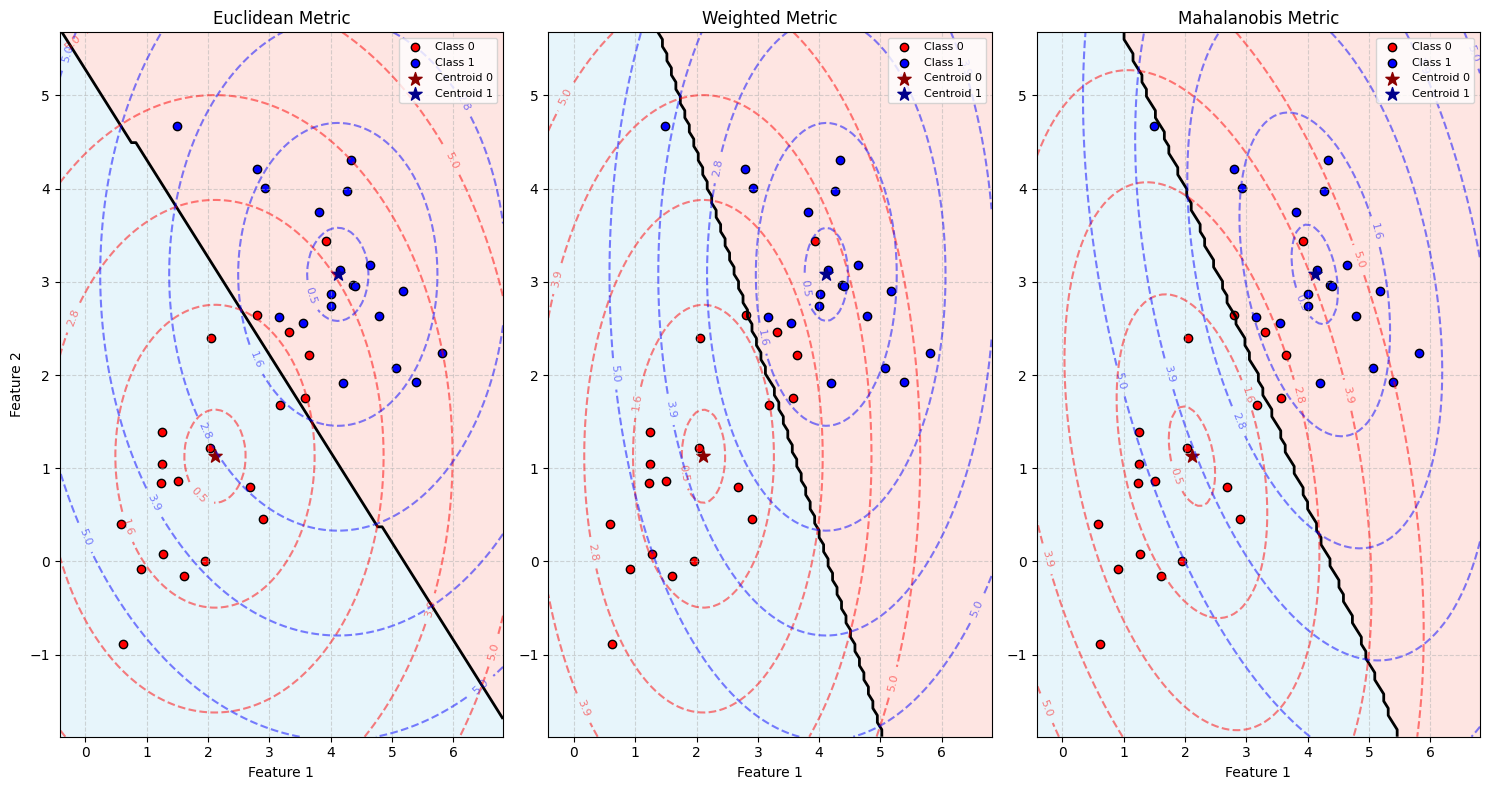

In [28]:
# Create synthetic data
torch.manual_seed(42)
n_samples = 40

# Generate two classes
mean1 = torch.tensor([2.0, 1.0])
mean2 = torch.tensor([4.0, 3.0])

# Create data with different covariance
cov1 = torch.tensor([[1.0, 0.8], [0.8, 1.0]])
cov2 = torch.tensor([[1.0, -0.5], [-0.5, 1.0]])

# Generate multivariate normal samples
L1 = torch.linalg.cholesky(cov1)
L2 = torch.linalg.cholesky(cov2)

# Class 0
samples1 = torch.randn(n_samples//2, 2) @ L1.T + mean1

# Class 1
samples2 = torch.randn(n_samples//2, 2) @ L2.T + mean2

# Combine the data
X = torch.cat([samples1, samples2], dim=0)
y = torch.cat([torch.zeros(n_samples//2), torch.ones(n_samples//2)])

# Define different inner product matrices
M_identity = torch.eye(2)  # Standard Euclidean inner product
M_weighted = torch.diag(torch.tensor([2.0, 1.0]))  # Weighted inner product
M_mahalanobis = torch.tensor([[2.0, 0.5], [0.5, 1.0]])  # Mahalanobis inner product

inner_product_matrices = [M_identity, M_weighted, M_mahalanobis]
names = ['Euclidean', 'Weighted', 'Mahalanobis']

# Visualize the effect of different inner products
visualize_inner_product_metrics(X, y, inner_product_matrices, names)


## 4.9 Inner Products and Kernel Methods

Inner products are closely related to kernel functions in machine learning, which implicitly compute 
inner products in high-dimensional feature spaces. Let's visualize simple kernel inner products:


In [29]:
def polynomial_kernel(x, y, degree=2):
    """
    Polynomial kernel function: (x·y + 1)^degree
    
    Args:
        x, y: Input vectors
        degree: Polynomial degree
        
    Returns:
        Kernel value
    """
    return (torch.dot(x, y) + 1) ** degree

def rbf_kernel(x, y, gamma=1.0):
    """
    Radial Basis Function kernel: exp(-gamma * ||x-y||²)
    
    Args:
        x, y: Input vectors
        gamma: RBF parameter
        
    Returns:
        Kernel value
    """
    return torch.exp(-gamma * torch.sum((x - y)**2))


In [30]:
def visualize_kernel_inner_products(points, figsize=(15, 5)):
    """
    Visualize different kernel inner products between 2D points.
    
    Args:
        points: Set of 2D points
        figsize: Figure size
    """
    # Number of points
    n_points = len(points)
    
    # Calculate kernel matrices
    linear_kernel = torch.zeros((n_points, n_points))
    poly_kernel = torch.zeros((n_points, n_points))
    rbf_kernel_matrix = torch.zeros((n_points, n_points))
    
    for i in range(n_points):
        for j in range(n_points):
            # Linear kernel (standard inner product)
            linear_kernel[i, j] = torch.dot(points[i], points[j])
            
            # Polynomial kernel
            poly_kernel[i, j] = polynomial_kernel(points[i], points[j], degree=2)
            
            # RBF kernel
            rbf_kernel_matrix[i, j] = rbf_kernel(points[i], points[j], gamma=0.5)
    
    # Set up the figure
    fig, axes = plt.subplots(1, 4, figsize=figsize)
    
    # Convert to numpy
    points_np = points.detach().cpu().numpy()
    linear_kernel_np = linear_kernel.detach().cpu().numpy()
    poly_kernel_np = poly_kernel.detach().cpu().numpy()
    rbf_kernel_np = rbf_kernel_matrix.detach().cpu().numpy()
    
    # Plot the points
    axes[0].scatter(points_np[:, 0], points_np[:, 1], s=100, c=range(n_points), 
                   cmap='viridis', edgecolor='k')
    
    for i, point in enumerate(points_np):
        axes[0].text(point[0], point[1], f'{i+1}', ha='center', va='center',
                    fontsize=10, color='white', fontweight='bold')
    
    axes[0].set_title('Data Points')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].grid(True)
    
    # Plot the kernel matrices
    kernel_matrices = [linear_kernel_np, poly_kernel_np, rbf_kernel_np]
    titles = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
    
    for i, (kernel_matrix, title) in enumerate(zip(kernel_matrices, titles)):
        im = axes[i+1].imshow(kernel_matrix, cmap=cmap)
        plt.colorbar(im, ax=axes[i+1])
        
        # Add the kernel values
        for row in range(n_points):
            for col in range(n_points):
                axes[i+1].text(col, row, f'{kernel_matrix[row, col]:.2f}', 
                              ha='center', va='center', 
                              color='black' if kernel_matrix[row, col] < 0.7*np.max(kernel_matrix) else 'white')
        
        axes[i+1].set_title(title)
        axes[i+1].set_xticks(range(n_points))
        axes[i+1].set_yticks(range(n_points))
        axes[i+1].set_xticklabels([f'x{j+1}' for j in range(n_points)])
        axes[i+1].set_yticklabels([f'x{j+1}' for j in range(n_points)])
    
    plt.tight_layout()
    plt.show()


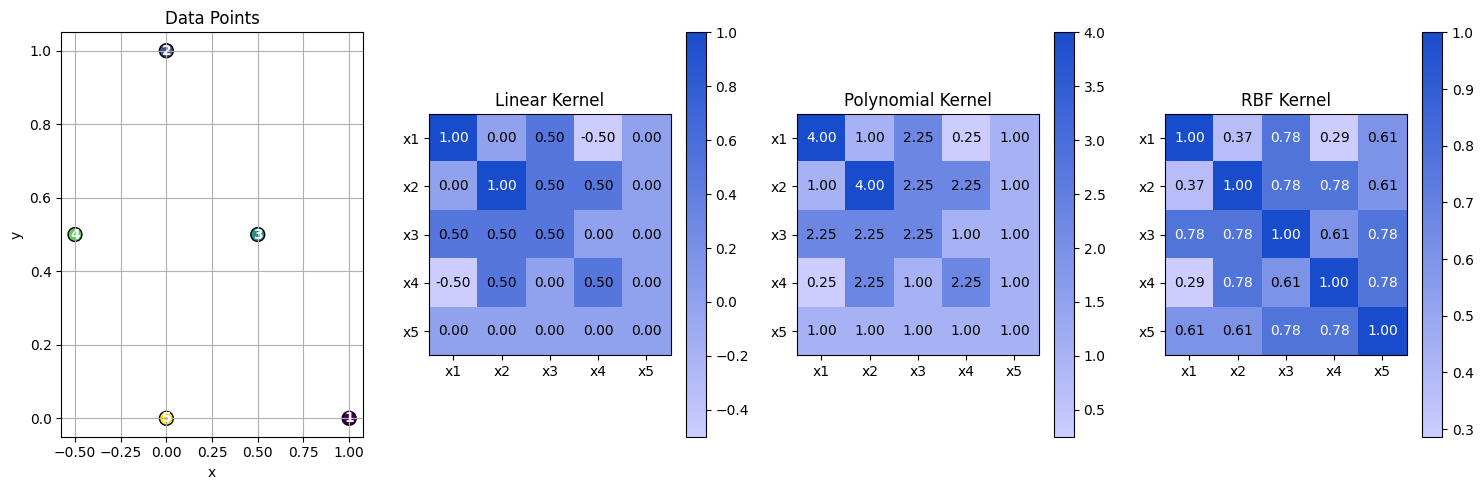

In [31]:
# Create some 2D points
points = torch.tensor([
    [1.0, 0.0],
    [0.0, 1.0],
    [0.5, 0.5],
    [-0.5, 0.5],
    [0.0, 0.0]
])

# Visualize different kernel inner products
visualize_kernel_inner_products(points)


## 4.10 Conclusion

In this tutorial, we've explored various inner product definitions and their applications:

- Standard dot products and their properties
- Weighted inner products for emphasizing certain dimensions
- Mahalanobis inner products that account for correlations between dimensions
- Inner products in function spaces
- Applications in orthogonal polynomials
- Using different inner products in machine learning
- Kernel methods as implicit inner products

Inner products are a fundamental concept that generalizes across many domains, from
simple vector operations to sophisticated machine learning algorithms. Understanding
different inner product definitions helps build intuition for how vectors and functions
can be compared and measured in various ways.